По датасету из вложения построить наилучший бинарный классификатор, целевой столбец – mark. Оформить в виде jupyter notebook либо .py скрипта (тогда вывод должен быть описан в отдельном файле txt/excel/etc.).

По стеку ограничений нет. Срок 1 день.

In [197]:
import torch
import numpy as np
import pandas as pd
import catboost
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, recall_score, f1_score, accuracy_score, precision_score
import matplotlib.pyplot as plt
import catboost.datasets as cbd
from sklearn.model_selection import GridSearchCV
import math



In [198]:
#dowload data
file_name = 'result_set.xlsx' 
df = pd.read_excel(file_name)
print(df.head())

       Ft 0      Ft 1      Ft 2      Ft 3       Ft 4      Ft 5       Ft 6  \
0  1.620967  1.056248  0.114203  6.175593   5.625789  0.581535   7.360085   
1  1.274494  0.814288  0.727210  3.606359   1.493780  7.810750  20.314335   
2  0.569931  1.607170  0.479581  3.521474   1.663726  2.297903  12.839282   
3  0.547560  1.724393  0.682358  1.809472  10.149721  2.999319  49.108530   
4  1.798884  1.748245  1.045646  1.560427   1.269053  1.403952   5.270951   

   Ft 7    Ft 8      Ft 9  Ft 10  Ft 11  Ft 12  Ft 13  Ft14        Ft15  \
0    68    male  very_low  535.0   True      5      5     0         NaN   
1    24  female      high  846.0  False      3      1     1  quite rich   
2    67    male      high  782.0  False      0      0     0    moderate   
3    42    male    medium  132.0  False      3      3     0  quite rich   
4    84    male  very_low  708.0  False      0      0     0         NaN   

                  Ft16  Ft17  mark  
0                  car     0     0  
1           

In [199]:
# print the size of data
print(df.shape)

(5000, 19)


In [200]:
#find missing data
print(df.isna().sum())


Ft 0       0
Ft 1       0
Ft 2       0
Ft 3       0
Ft 4       0
Ft 5       0
Ft 6       0
Ft 7       0
Ft 8       0
Ft 9       0
Ft 10     64
Ft 11     50
Ft 12      0
Ft 13      0
Ft14       0
Ft15     817
Ft16       0
Ft17       0
mark       0
dtype: int64


In [201]:
#find columns that have null
print(df.isnull().sum())

Ft 0       0
Ft 1       0
Ft 2       0
Ft 3       0
Ft 4       0
Ft 5       0
Ft 6       0
Ft 7       0
Ft 8       0
Ft 9       0
Ft 10     64
Ft 11     50
Ft 12      0
Ft 13      0
Ft14       0
Ft15     817
Ft16       0
Ft17       0
mark       0
dtype: int64


In [202]:
# NUll change to 0 value for Ft10 feature
df['Ft 10']=df['Ft 10'].fillna(0)
df['Ft 10'].value_counts()

Ft 10
266.0    368
0.0       64
243.0     39
247.0     35
144.0     33
        ... 
361.0      1
333.0      1
932.0      1
347.0      1
561.0      1
Name: count, Length: 546, dtype: int64

In [203]:
# replace Nan to NULL because if I drop all NaN, I lost around 20% of data. Actually, I tried to drop, but I got lower metrics. 
df = df.fillna('')
df = df.replace('', 'NULL')

print(df.shape)
df.head()


(5000, 19)


,Ft 0,Ft 1,Ft 2,Ft 3,Ft 4,Ft 5,Ft 6,Ft 7,Ft 8,Ft 9,Ft 10,Ft 11,Ft 12,Ft 13,Ft14,Ft15,Ft16,Ft17,mark
0,1.620967,1.056248,0.114203,6.175593,5.625789,0.581535,7.360085,68,male,very_low,535.0,True,5,5,0,NULL,car,0,0
1,1.274494,0.814288,0.727210,3.606359,1.493780,7.810750,20.314335,24,female,high,846.0,False,3,1,1,quite rich,car,1,0
2,0.569931,1.607170,0.479581,3.521474,1.663726,2.297903,12.839282,67,male,high,782.0,False,0,0,0,moderate,furniture/equipment,1,0
3,0.547560,1.724393,0.682358,1.809472,10.149721,2.999319,49.108530,42,male,medium,132.0,False,3,3,0,quite rich,car,0,0
4,1.798884,1.748245,1.045646,1.560427,1.269053,1.403952,5.270951,84,male,very_low,708.0,False,0,0,0,NULL,radio/TV,1,0


In [204]:
# drop target value
X=df.drop('mark', axis=1)
X

,Ft 0,Ft 1,Ft 2,Ft 3,Ft 4,Ft 5,Ft 6,Ft 7,Ft 8,Ft 9,Ft 10,Ft 11,Ft 12,Ft 13,Ft14,Ft15,Ft16,Ft17
0,1.620967,1.056248,0.114203,6.175593,5.625789,0.581535,7.360085,68,male,very_low,535.0,True,5,5,0,NULL,car,0
1,1.274494,0.814288,0.727210,3.606359,1.493780,7.810750,20.314335,24,female,high,846.0,False,3,1,1,quite rich,car,1
2,0.569931,1.607170,0.479581,3.521474,1.663726,2.297903,12.839282,67,male,high,782.0,False,0,0,0,moderate,furniture/equipment,1
3,0.547560,1.724393,0.682358,1.809472,10.149721,2.999319,49.108530,42,male,medium,132.0,False,3,3,0,quite rich,car,0
4,1.798884,1.748245,1.045646,1.560427,1.269053,1.403952,5.270951,84,male,very_low,708.0,False,0,0,0,NULL,radio/TV,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.559134,0.536588,1.279125,0.929000,7.795273,0.516629,3.664827,18,male,high,243.0,False,4,3,0,NULL,car,1
4996,1.857942,0.976926,0.513208,0.707998,0.176079,0.444542,10.778070,78,male,high,643.0,True,2,2,0,moderate,domestic appliances,0
4997,1.207780,0.782006,0.557193,0.186188,1.029377,0.546945,16.717601,70,male,low,690.0,True,5,3,0,little,domestic appliances,0
4998,0.579599,1.191785,0.499301,1.139520,0.080799,0.261127,23.748920,84,female,very_low,498.0,False,5,3,0,little,radio/TV,0


In [205]:
#get target value
target=df['mark']
target

0       0
1       0
2       0
3       0
4       0
       ..
4995    0
4996    0
4997    0
4998    0
4999    0
Name: mark, Length: 5000, dtype: int64

In [206]:
# Сhecking if my target is balanced. So, it is not, later I will apply oversampling
target.value_counts()

mark
0    4936
1      64
Name: count, dtype: int64

In [207]:
# find all numerical and categorical features 
numeric_indices = np.array([0, 1, 2, 3, 4, 5 ,6, 7, 10, 12, 13, 14, 17])
categorical_indices = np.array([8, 9, 11, 15, 16])

In [208]:
#  look at numerical data
numeric_data = X[X.columns[numeric_indices]]
numeric_data.head()

,Ft 0,Ft 1,Ft 2,Ft 3,Ft 4,Ft 5,Ft 6,Ft 7,Ft 10,Ft 12,Ft 13,Ft14,Ft17
0,1.620967,1.056248,0.114203,6.175593,5.625789,0.581535,7.360085,68,535.0,5,5,0,0
1,1.274494,0.814288,0.727210,3.606359,1.493780,7.810750,20.314335,24,846.0,3,1,1,1
2,0.569931,1.607170,0.479581,3.521474,1.663726,2.297903,12.839282,67,782.0,0,0,0,1
3,0.547560,1.724393,0.682358,1.809472,10.149721,2.999319,49.108530,42,132.0,3,3,0,0
4,1.798884,1.748245,1.045646,1.560427,1.269053,1.403952,5.270951,84,708.0,0,0,0,1


In [209]:
#  look at categorial data
categorial_data = X[X.columns[categorical_indices]]
categorial_data.head()

,Ft 8,Ft 9,Ft 11,Ft15,Ft16
0,male,very_low,True,NULL,car
1,female,high,False,quite rich,car
2,male,high,False,moderate,furniture/equipment
3,male,medium,False,quite rich,car
4,male,very_low,False,NULL,radio/TV


In [216]:
#split data to train and test sets
categorial_data=categorial_data.astype("str")
X=pd.concat([numeric_data, categorial_data ], axis=1)
X_train=X.sample(frac=0.8,random_state=42)
X_test=X.drop(X_train.index)
y_train=target.sample(frac=0.8,random_state=42)
y_test=target.drop(y_train.index)


#X_train, X_test, y_train, y_test = train_test_split(X.values, target.values,
                                                      # train_size=0.8,
                                                       #random_state=42)
                                                       


Модель 1

In [282]:

clf = catboost.CatBoostClassifier(cat_features=categorical_indices)
import imblearn
from imblearn.over_sampling import SMOTENC

categorical_indices = ['Ft 8', 'Ft 9', 'Ft 11', 'Ft15', 'Ft16']
smote = SMOTENC(categorical_features=categorical_indices)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
# list a few parameters that we can tune 
param_grid = {
    
    
    'learning_rate': [0.01, 0.03, 0.001],
    'depth': [1, 2, 3, 5, 8],
    'l2_leaf_reg': [3, 5, 8],
    'n_estimators' : [400, 500],
    
}

#  GridSearchCV
search = GridSearchCV(clf, param_grid, n_jobs=-1, cv=5, refit=True, scoring='f1')

# start to search parameters
search.fit(X_resampled, y_resampled)

# print the best result of GridSearch
print(search.best_params_)



0:	learn: 0.6634049	total: 40.7ms	remaining: 20.3s
1:	learn: 0.6366740	total: 85.2ms	remaining: 21.2s
2:	learn: 0.6137033	total: 128ms	remaining: 21.3s
3:	learn: 0.5888263	total: 172ms	remaining: 21.4s
4:	learn: 0.5644828	total: 219ms	remaining: 21.7s
5:	learn: 0.5440243	total: 271ms	remaining: 22.3s
6:	learn: 0.5255080	total: 324ms	remaining: 22.8s
7:	learn: 0.5077347	total: 377ms	remaining: 23.2s
8:	learn: 0.4919668	total: 423ms	remaining: 23.1s
9:	learn: 0.4744250	total: 467ms	remaining: 22.9s
10:	learn: 0.4592357	total: 511ms	remaining: 22.7s
11:	learn: 0.4443027	total: 557ms	remaining: 22.7s
12:	learn: 0.4318980	total: 602ms	remaining: 22.6s
13:	learn: 0.4186746	total: 647ms	remaining: 22.5s
14:	learn: 0.4068692	total: 690ms	remaining: 22.3s
15:	learn: 0.3953633	total: 734ms	remaining: 22.2s
16:	learn: 0.3851041	total: 782ms	remaining: 22.2s
17:	learn: 0.3759188	total: 825ms	remaining: 22.1s
18:	learn: 0.3672703	total: 872ms	remaining: 22.1s
19:	learn: 0.3585549	total: 916ms	remai

Параметры гридсерч будут использованы чуточку позже. 

In [288]:
# fit model with the best parameters
import imblearn
from imblearn.over_sampling import SMOTENC

categorical_indices = ['Ft 8', 'Ft 9', 'Ft 11', 'Ft15', 'Ft16']


smote = SMOTENC(categorical_features=categorical_indices)

X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

boosting_model = catboost.CatBoostClassifier(cat_features= categorical_indices, class_weights={0: 1, 1:10}, n_estimators=400,
                                              depth = 5, l2_leaf_reg= 4, learning_rate= 0.03, loss_function='Logloss', verbose=0, early_stopping_rounds=10, custom_metric = 'F1' )

boosting_model.fit(X_train, y_train)

y_train_predicted = boosting_model.predict_proba(X_train)[:, 1]
y_test_predicted = boosting_model.predict_proba(X_test)[:, 1]


In [191]:
print(X_resampled.shape)

(7894, 18)


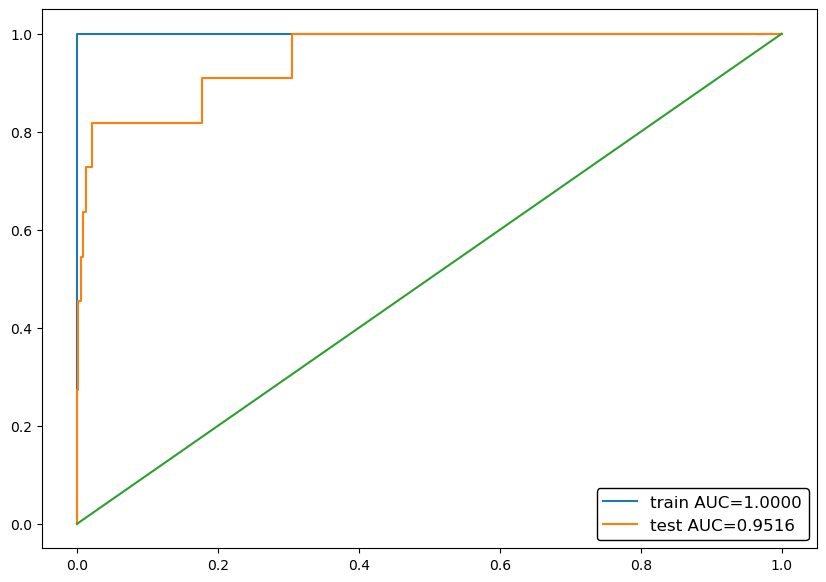

In [289]:
#plot roc_auc metric
train_auc = roc_auc_score(y_train, y_train_predicted)
test_auc = roc_auc_score(y_test, y_test_predicted)

plt.figure(figsize=(10,7))
plt.plot(*roc_curve(y_train, y_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(y_test, y_test_predicted)[:2], label='test AUC={:.4f}'.format(test_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()

In [291]:
y_test_predict = boosting_model.predict(X_test)
y_train_predict = boosting_model.predict(X_train)


In [292]:
#calculate other metrics for train and test data
print('train')
print ( 'Accuracy:', accuracy_score(y_train, y_train_predict))
print ('F1 score:', f1_score(y_train, y_train_predict))
print ('Recall:', recall_score(y_train, y_train_predict))
print ('Precision:', precision_score(y_train, y_train_predict))
print('test')
print ( 'Accuracy:', accuracy_score(y_test, y_test_predict))
print ('F1 score:', f1_score(y_test, y_test_predict))
print ('Recall:', recall_score(y_test, y_test_predict))
print ('Precision:', precision_score(y_test, y_test_predict))

train
Accuracy: 1.0
F1 score: 1.0
Recall: 1.0
Precision: 1.0
test
Accuracy: 0.991
F1 score: 0.47058823529411764
Recall: 0.36363636363636365
Precision: 0.6666666666666666


In [195]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_predict))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       989
           1       0.67      0.36      0.47        11

    accuracy                           0.99      1000
   macro avg       0.83      0.68      0.73      1000
weighted avg       0.99      0.99      0.99      1000



Посчитаем метрики для таргета. В целом, видно, что для траин сета произошло переобучение. Параметры для модели были взяты из предыдущих настроек, которые не включены в этот нотбук. Уже для текущей модели, с учетом расширения данных был чуть ранее запущен GridSearch для поиска оптимальных параметров. Получила, что оптимальные параметры {'depth': 8, 'l2_leaf_reg': 3, 'learning_rate': 0.03, 'n_estimators': 500}

In [196]:
y_predict = boosting_model.predict(X)
print('target')
print ( 'Accuracy:', accuracy_score(target, y_predict))
print ('F1 score:', f1_score(target, y_predict))
print ('Recall:', recall_score(target, y_predict))
print ('Precision:', precision_score(target, y_predict))

target
Accuracy: 0.9982
F1 score: 0.926829268292683
Recall: 0.890625
Precision: 0.9661016949152542


применим результаты грид серч к нашей модели.

Модель 2

In [298]:


X_resampled_grid, y_resampled_grid = X_resampled, y_resampled

boosting_model = catboost.CatBoostClassifier(cat_features= categorical_indices, class_weights={0: 1, 1:10}, n_estimators=500,
                                              depth = 8, l2_leaf_reg= 3, learning_rate= 0.03, loss_function='Logloss', verbose=0, early_stopping_rounds=10, custom_metric = 'F1' )

boosting_model.fit(X_resampled_grid, y_resampled_grid)

y_train_predicted_grid = boosting_model.predict_proba(X_train)[:, 1]
y_test_predicted_grid = boosting_model.predict_proba(X_test)[:, 1]


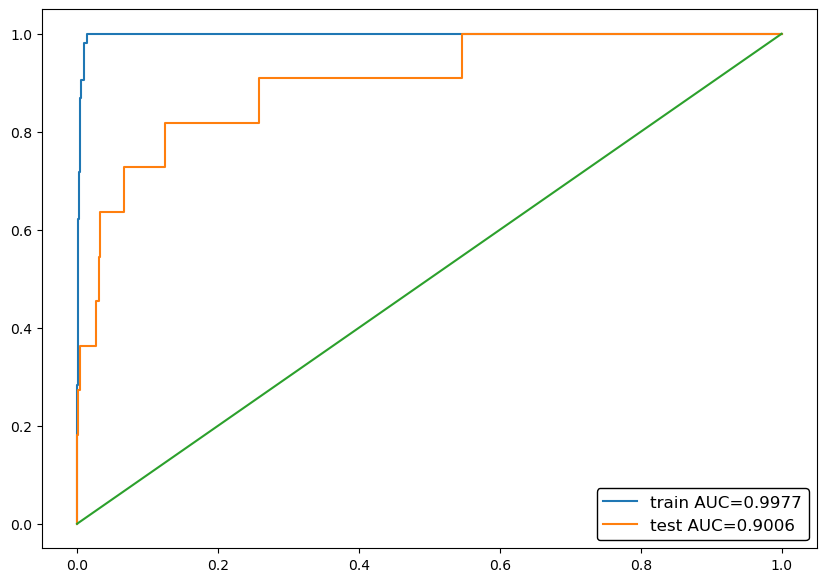

In [299]:
#plot roc_auc metric
train_auc = roc_auc_score(y_train, y_train_predicted_grid)
test_auc = roc_auc_score(y_test, y_test_predicted_grid)

plt.figure(figsize=(10,7))
plt.plot(*roc_curve(y_train, y_train_predicted_grid)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(y_test, y_test_predicted_grid)[:2], label='test AUC={:.4f}'.format(test_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()

In [300]:
y_test_predict_grid = boosting_model.predict(X_test)
y_train_predict_grid= boosting_model.predict(X_train)
#calculate other metrics for train and test data
print('train')
print ( 'Accuracy:', accuracy_score(y_train, y_train_predict_grid))
print ('F1 score:', f1_score(y_train, y_train_predict_grid))
print ('Recall:', recall_score(y_train, y_train_predict_grid))
print ('Precision:', precision_score(y_train, y_train_predict_grid))
print('test')
print ( 'Accuracy:', accuracy_score(y_test, y_test_predict_grid))
print ('F1 score:', f1_score(y_test, y_test_predict_grid))
print ('Recall:', recall_score(y_test, y_test_predict_grid))
print ('Precision:', precision_score(y_test, y_test_predict_grid))
y_predict_grid = boosting_model.predict(X)
print('target')
print ( 'Accuracy:', accuracy_score(target, y_predict_grid))
print ('F1 score:', f1_score(target, y_predict_grid))
print ('Recall:', recall_score(target, y_predict_grid))
print ('Precision:', precision_score(target, y_predict_grid))

train
Accuracy: 0.965
F1 score: 0.43089430894308944
Recall: 1.0
Precision: 0.27461139896373055
test
Accuracy: 0.945
F1 score: 0.2028985507246377
Recall: 0.6363636363636364
Precision: 0.1206896551724138
target
Accuracy: 0.961
F1 score: 0.38095238095238093
Recall: 0.9375
Precision: 0.23904382470119523


Модель 3

Видно, что характеристики сильно ухудшились, необходимо дальше поработать с поисками параметров, поиследовать значения в других диапазонах. Например, глубина была подобрана как 8, но это было максимальное значение из списка в данном гридсерче, возможно значение 7 или 9 лучше подойдет. Аналогично и с другими параметрами. 

Далее решила посмотреть есть ли корреляция между данными, возможно, какие-то фичи стоит исключить из обучения. 

In [225]:
#find correlation between data

import seaborn as sns
numeric_data.corr()

,Ft 0,Ft 1,Ft 2,Ft 3,Ft 4,Ft 5,Ft 6,Ft 7,Ft 10,Ft 12,Ft 13,Ft14,Ft17
Ft 0,1.000000,-0.015886,0.018935,-0.013500,-0.002741,0.028186,-0.008262,0.003396,-0.010030,-0.036546,-0.035363,0.003750,0.002680
Ft 1,-0.015886,1.000000,-0.016031,-0.028624,-0.015332,-0.023348,-0.025739,-0.006974,0.010123,-0.009593,-0.006867,0.012427,0.017420
Ft 2,0.018935,-0.016031,1.000000,-0.250747,-0.157553,-0.074329,-0.254771,-0.006418,0.011736,-0.004450,-0.005563,-0.003151,0.007745
Ft 3,-0.013500,-0.028624,-0.250747,1.000000,0.295277,0.151203,0.226721,-0.004597,-0.022376,0.016635,0.015077,0.008386,-0.016522
Ft 4,-0.002741,-0.015332,-0.157553,0.295277,1.000000,0.281199,0.277990,-0.005463,-0.041608,0.010805,0.011800,-0.002774,-0.005746
Ft 5,0.028186,-0.023348,-0.074329,0.151203,0.281199,1.000000,0.521435,0.016540,0.002044,-0.000892,-0.001747,-0.003162,-0.006156
Ft 6,-0.008262,-0.025739,-0.254771,0.226721,0.277990,0.521435,1.000000,0.003986,-0.007213,0.005847,0.004872,0.012947,-0.026573
Ft 7,0.003396,-0.006974,-0.006418,-0.004597,-0.005463,0.016540,0.003986,1.000000,-0.011130,-0.000340,0.001497,-0.582453,0.003900
Ft 10,-0.010030,0.010123,0.011736,-0.022376,-0.041608,0.002044,-0.007213,-0.011130,1.000000,0.015236,0.012614,0.254947,-0.055500
Ft 12,-0.036546,-0.009593,-0.004450,0.016635,0.010805,-0.000892,0.005847,-0.000340,0.015236,1.000000,0.997445,0.012223,-0.009605


<Axes: >

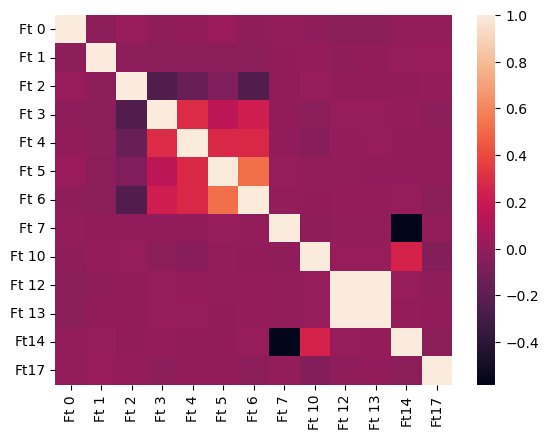

In [226]:
sns.heatmap(numeric_data.corr())


Видно, что фича 5 и 6, 12 и 13 коррелируют между собой. Следовательно, можно удалить одну из них, например, 6 и 13. 

In [270]:
numeric_indices_drop = np.array([0, 1, 2, 3, 4, 5, 7, 10, 12, 14, 17])
X_new=df.drop('mark', axis=1)
numeric_data_drop = X_new[X_new.columns[numeric_indices_drop]]
numeric_data_drop


,Ft 0,Ft 1,Ft 2,Ft 3,Ft 4,Ft 5,Ft 7,Ft 10,Ft 12,Ft14,Ft17
0,1.620967,1.056248,0.114203,6.175593,5.625789,0.581535,68,535.0,5,0,0
1,1.274494,0.814288,0.727210,3.606359,1.493780,7.810750,24,846.0,3,1,1
2,0.569931,1.607170,0.479581,3.521474,1.663726,2.297903,67,782.0,0,0,1
3,0.547560,1.724393,0.682358,1.809472,10.149721,2.999319,42,132.0,3,0,0
4,1.798884,1.748245,1.045646,1.560427,1.269053,1.403952,84,708.0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
4995,0.559134,0.536588,1.279125,0.929000,7.795273,0.516629,18,243.0,4,0,1
4996,1.857942,0.976926,0.513208,0.707998,0.176079,0.444542,78,643.0,2,0,0
4997,1.207780,0.782006,0.557193,0.186188,1.029377,0.546945,70,690.0,5,0,0
4998,0.579599,1.191785,0.499301,1.139520,0.080799,0.261127,84,498.0,5,0,0


In [271]:
categorial_data=categorial_data.astype("str")
X_drop=pd.concat([numeric_data_drop, categorial_data], axis=1)
X_train_drop=X_drop.sample(frac=0.8,random_state=42)
X_test_drop=X_drop.drop(X_train_drop.index)
y_train_drop=target.sample(frac=0.8,random_state=42)
y_test_drop=target.drop(y_train_drop.index)

In [272]:
numeric_data_drop

,Ft 0,Ft 1,Ft 2,Ft 3,Ft 4,Ft 5,Ft 7,Ft 10,Ft 12,Ft14,Ft17
0,1.620967,1.056248,0.114203,6.175593,5.625789,0.581535,68,535.0,5,0,0
1,1.274494,0.814288,0.727210,3.606359,1.493780,7.810750,24,846.0,3,1,1
2,0.569931,1.607170,0.479581,3.521474,1.663726,2.297903,67,782.0,0,0,1
3,0.547560,1.724393,0.682358,1.809472,10.149721,2.999319,42,132.0,3,0,0
4,1.798884,1.748245,1.045646,1.560427,1.269053,1.403952,84,708.0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
4995,0.559134,0.536588,1.279125,0.929000,7.795273,0.516629,18,243.0,4,0,1
4996,1.857942,0.976926,0.513208,0.707998,0.176079,0.444542,78,643.0,2,0,0
4997,1.207780,0.782006,0.557193,0.186188,1.029377,0.546945,70,690.0,5,0,0
4998,0.579599,1.191785,0.499301,1.139520,0.080799,0.261127,84,498.0,5,0,0


Запускала даннный гридсерч ранее и выдал наилучшие результаты depth = 8, l2_leaf_reg= 3, learning_rate= 0.03. Далее решила сделать исследование параметров близко в данных областях, но уж слишком большая глубина и данный расчет не успел досчитаться. Поэтому далее будут представлены результаты для найденных ранее параметров.

Модель 4

In [ ]:
clf = catboost.CatBoostClassifier(cat_features=categorical_indices)
import imblearn
from imblearn.over_sampling import SMOTENC

categorical_indices = ['Ft 8', 'Ft 9', 'Ft 11', 'Ft15', 'Ft16']
smote_2 = SMOTENC(categorical_features=categorical_indices)
X_resampled_drop, y_resampled_drop = smote_2.fit_resample(X_train_drop, y_train_drop)
# list a few parameters that we can tune 
param_grid = {
    
    
    'learning_rate': [0.01, 0.03, 0.001],
    'depth': [7, 8, 10, 12, 14],
    'l2_leaf_reg': [3, 5, 8],
    'n_estimators' : [400, 500,700],
    
}

#  GridSearchCV
search_2 = GridSearchCV(clf, param_grid, n_jobs=-1, cv=5, refit=True, scoring='f1')

# start to search parameters
search_2.fit(X_resampled_drop, y_resampled_drop)

# print the best result of GridSearch
print(search_2.best_params_)


In [293]:
import imblearn
from imblearn.over_sampling import SMOTENC

categorical_indices = ['Ft 8', 'Ft 9', 'Ft 11', 'Ft15', 'Ft16']


smote = SMOTENC(categorical_features=categorical_indices)

X_resampled_drop, y_resampled_drop = smote.fit_resample(X_train_drop, y_train_drop)

boosting_model = catboost.CatBoostClassifier(cat_features= categorical_indices, class_weights={0: 1, 1:10}, n_estimators=500,
                                              depth = 8, l2_leaf_reg= 3, learning_rate= 0.03, loss_function='Logloss', verbose=0, early_stopping_rounds=10, custom_metric = 'F1' )

boosting_model.fit(X_train_drop, y_train_drop)

y_train_predicted_drop = boosting_model.predict_proba(X_train_drop)[:, 1]
y_test_predicted_drop = boosting_model.predict_proba(X_test_drop)[:, 1]


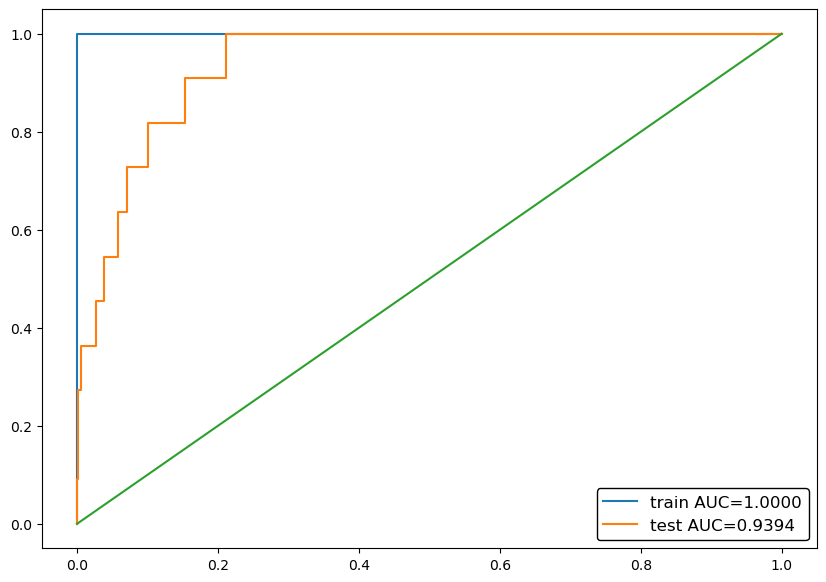

In [294]:
#plot roc_auc metric
train_auc = roc_auc_score(y_train_drop, y_train_predicted_drop)
test_auc = roc_auc_score(y_test_drop, y_test_predicted_drop)

plt.figure(figsize=(10,7))
plt.plot(*roc_curve(y_train_drop, y_train_predicted_drop)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(y_test_drop, y_test_predicted_drop)[:2], label='test AUC={:.4f}'.format(test_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()

In [295]:
y_test_predict_drop = boosting_model.predict(X_test_drop)
y_train_predict_drop = boosting_model.predict(X_train_drop)

In [296]:
#calculate other metrics for train and test data
print('train')
print ( 'Accuracy:', accuracy_score(y_train_drop, y_train_predict_drop))
print ('F1 score:', f1_score(y_train_drop, y_train_predict_drop))
print ('Recall:', recall_score(y_train_drop, y_train_predict_drop))
print ('Precision:', precision_score(y_train_drop, y_train_predict_drop))
print('test')
print ( 'Accuracy:', accuracy_score(y_test_drop, y_test_predict_drop))
print ('F1 score:', f1_score(y_test_drop, y_test_predict_drop))
print ('Recall:', recall_score(y_test_drop, y_test_predict_drop))
print ('Precision:', precision_score(y_test_drop, y_test_predict_drop))


train
Accuracy: 1.0
F1 score: 1.0
Recall: 1.0
Precision: 1.0
test
Accuracy: 0.989
F1 score: 0.15384615384615385
Recall: 0.09090909090909091
Precision: 0.5


аналогично, как и ранее на траине сильное переобучение. Собственное, поэтому был и запущен еще раз грид серч чтобы получше поиследовать данные. 

Модель 5

Также были проведенны расчеты, когда категориальные признаки кодируются one-hot encoding и все данные нормализуются StandardScaler, аналогичным образом был запущен грид серч и oversampling для данных SMOTE (см. другой нотбук, здесь будут только результаты). Но так как фичей становится в несколько раз больше, а именно 580, то необходимо использовать деревья глубокой глубины, что требует больше времени на расчеты. Прикрепляю результаты. 

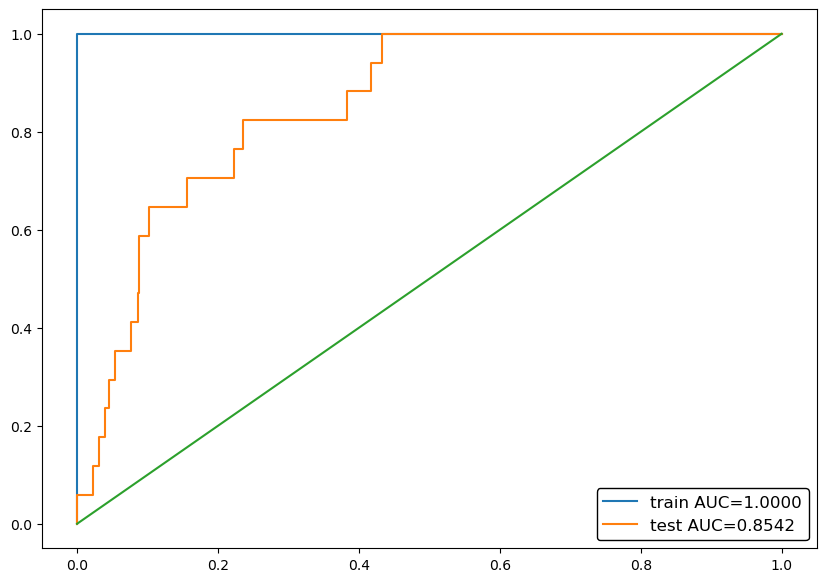

target
Accuracy: 0.9942
F1 score: 0.768
Recall: 0.75
Precision: 0.7868852459016393

Так же хотелось отметить, что 1) в первых расчетых аналогичным образом можно было нормализовать численные данные, т.к. большинство данных имеют большой диапазон значений. 
2) Данные несбалансированные, были применены веса для каждого класса при обучении, но помимо этого можно было попробовать использовать focal_loss. Данная лосс функция обычно показывает хорошие результаты.
3) Пропуски в данных были заполнены 0 или Null, возможно стоит тоже с этим поработать, посмотреть как коррелируют данные и что значат фичи. Однозначно убирать данные не стоит, их и так слишком мало.  

В целом, я считаю, что наилучшие результаты показала самая первая модель, где было 18 фичей, оверсамплинг, применены веса для каждого класса. Необходимо дальше с ней работать и настраивать параметры и как минимум добавить нормализацию данных. 


